In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_validate
from sklearn import metrics
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
#import xgboost as XGBClassifier
from xgboost import XGBClassifier

import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer
from wordcloud import STOPWORDS, WordCloud

import re
import string
from textblob import TextBlob

from functools import partial

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
# Read dataset
df = pd.read_excel('/content/code-review-dataset-full.xlsx')
df.head(10)

,message,is_toxic
0,This and below assignments also should be removed,0
1,this should be flavor_id = self.flavor_id,0
2,bool session_adopted_ = false;,0
3,"nit: Starting C++11, this could be done direct...",0
4,I am confused.\n \n This is the tar process we...,0
5,"Yuck. Use %.70s, which will do this more grace...",1
6,Use mock_thread_instance = mock.MagicMock(isAl...,0
7,SkRect local_bounds = gfx::RectToSkRect(GetLoc...,0
8,worse!!!!!!! how does setuptools/cliff even do...,0
9,so you have rename fields to obj_fields becaus...,0


##**EDA**

In [3]:
df.shape

(19651, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19651 entries, 0 to 19650
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   message   19647 non-null  object
 1   is_toxic  19651 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 307.2+ KB


In [5]:

df.describe()

,is_toxic
count,19651.000000
mean,0.191186
std,0.393245
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [6]:
# Check duplicates
df.duplicated().sum()

6746

In [7]:
# Drop duplicates
df = df.drop_duplicates(keep= 'first')
df.shape

(12905, 2)

In [8]:
# Check null comments
df.isnull().sum()

message     1
is_toxic    0
dtype: int64

In [9]:
# Drop null line
df = df.dropna()
df

,message,is_toxic
0,This and below assignments also should be removed,0
1,this should be flavor_id = self.flavor_id,0
2,bool session_adopted_ = false;,0
3,"nit: Starting C++11, this could be done direct...",0
4,I am confused.\n \n This is the tar process we...,0
...,...,...
19646,Amazing!!! I bet that contributed a lot to our...,0
19647,great catch,0
19648,"Wow, this is amazing.",0
19649,This is awesome.,0


In [10]:
# number of toxic comments
df[df["is_toxic"]==1].shape

(2522, 2)

In [11]:
# Number of non-toxic comments
df[df["is_toxic"]==0].shape

(10382, 2)

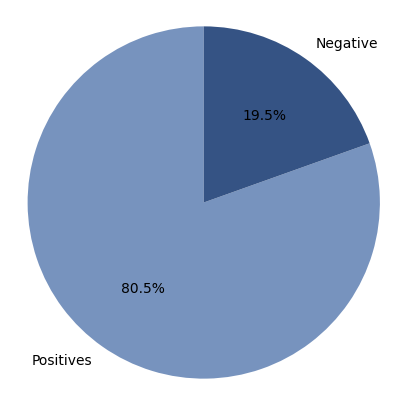

In [12]:
# Make a pie plot to check target class balanced or not
fig = plt.figure(figsize=(5, 5))
labels = 'Positives', 'Negative'
sizes = [df[df["is_toxic"]==0].shape[0], df[df["is_toxic"]==1].shape[0]]
plt.pie(sizes, labels=labels, colors= ['#7793BE', '#355384'], autopct='%1.1f%%',
        startangle=90)
plt.axis('equal')
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


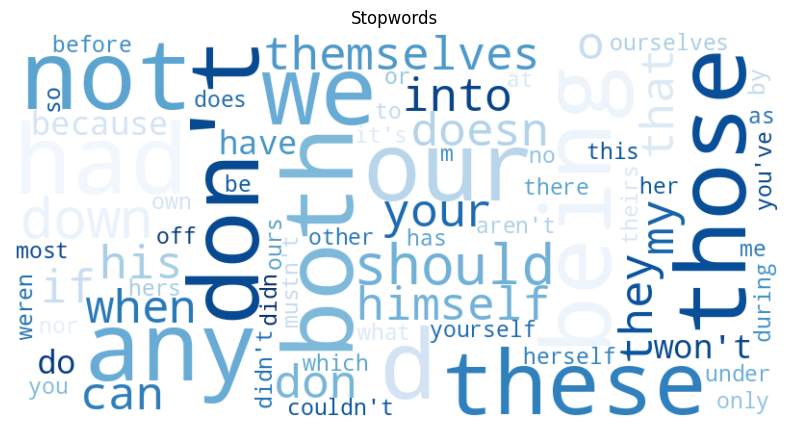

In [15]:
# stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

# Create a WordCloud with stopwords
wordcloud = WordCloud(width=800, height=400, background_color="white",
                      stopwords=stop_words, min_font_size= 20, max_font_size = 100,
                      colormap = 'Blues_r').generate_from_frequencies(dict.fromkeys(stop_words, 1))

# Plot the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Stopwords")
plt.show()

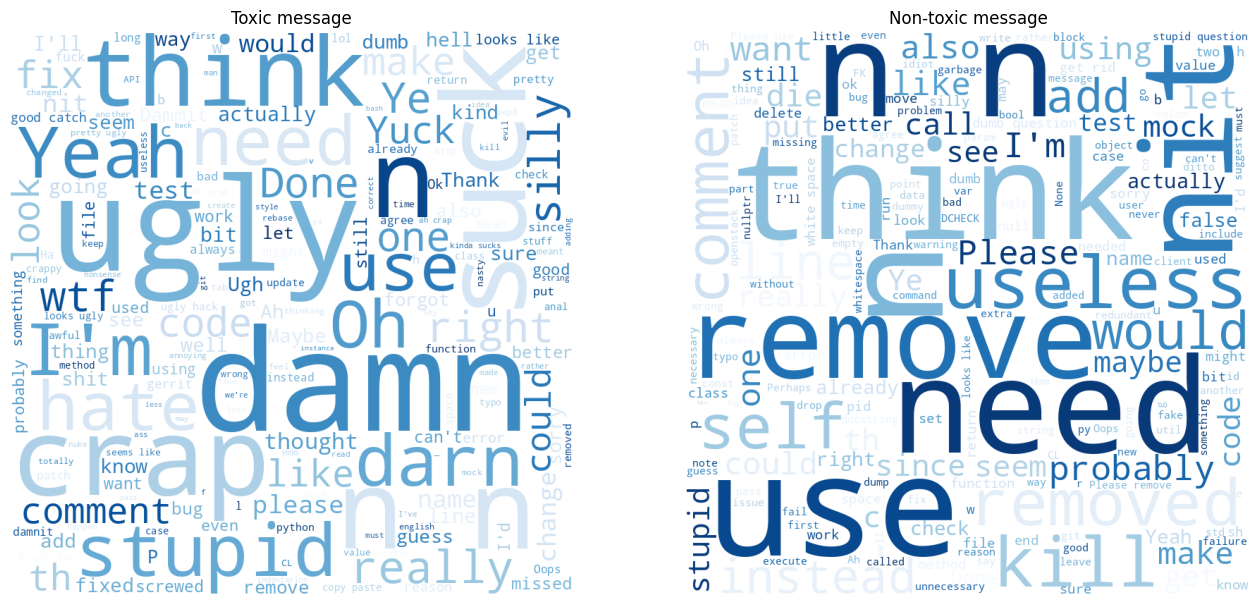

In [ ]:
# Plot negative and non-toxic review/comments
negative_cmt = df["message"][df["is_toxic"]==1].to_string()
wordcloud_toxic = WordCloud(width= 800, height= 800, background_color = 'white',
                               stopwords= stop_words, min_font_size= 10, max_font_size = 200,
                               colormap = 'Blues_r').generate(negative_cmt)

nontoxic_cmt = df["message"][df["is_toxic"]==0].to_string()
wordcloud_nontoxic = WordCloud(width= 800, height= 800, stopwords= stop_words,
                               background_color= 'white', min_font_size= 11,
                               max_font_size = 200, colormap = 'Blues_r').generate(nontoxic_cmt)

plt.figure(figsize = (16,8))

plt.subplot(1,2,1)
plt.title('Toxic message')
plt.axis('off')
plt.imshow(wordcloud_toxic)

plt.subplot(1,2,2)
plt.title('Non-toxic message')
plt.axis('off')
plt.imshow(wordcloud_nontoxic)
plt.show()

##**Feature engineering**


In [ ]:
df1 = df.copy()
df1['num_words'] = df1['message'].apply(lambda x: len(x.split()))
df1['num_char'] = df1['message'].apply(lambda x: sum(list(map(len,x.split()))))
df1['upper_case'] = df1['message'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
df1['num_punctuations'] = df1['message'].str.count('[.,:;]')
df1['num_exclamation_mark'] = df1['message'].str.count('\!')
df1['num_question_mark'] = df1['message'].str.count('\?')
df1

,message,is_toxic,num_words,num_char,upper_case,num_punctuations,num_exclamation_mark,num_question_mark
0,This and below assignments also should be removed,0,8,42,0,0,0,0
1,this should be flavor_id = self.flavor_id,0,6,36,0,1,0,0
2,bool session_adopted_ = false;,0,4,27,0,1,0,0
3,"nit: Starting C++11, this could be done direct...",0,16,81,1,4,0,0
4,I am confused.\n \n This is the tar process we...,0,33,139,1,4,0,2
...,...,...,...,...,...,...,...,...
19646,Amazing!!! I bet that contributed a lot to our...,0,15,67,1,1,4,0
19647,great catch,0,2,10,0,0,0,0
19648,"Wow, this is amazing.",0,4,18,0,2,0,0
19649,This is awesome.,0,3,14,0,1,0,0


Text(0.5, 0.98, 'Features distribution')

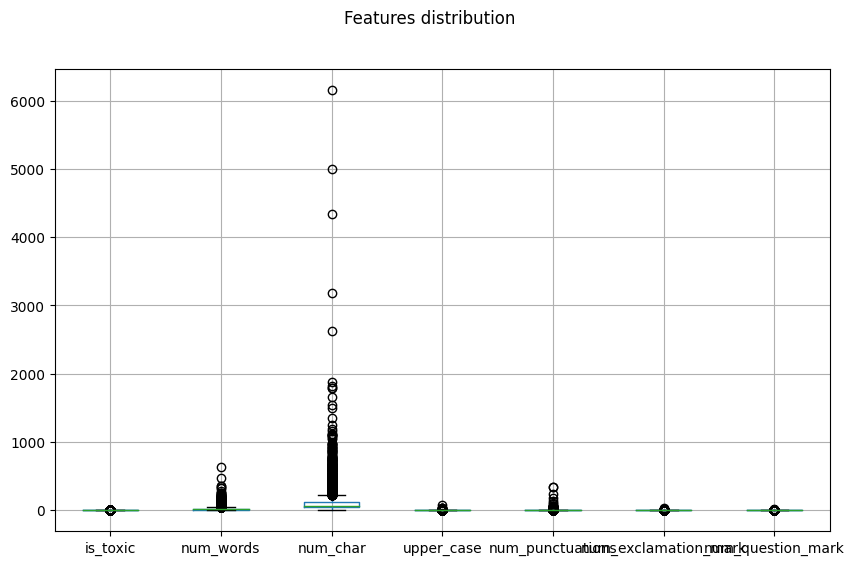

In [ ]:
# Check outliers
df1_boxplot = df1.boxplot(figsize= (10, 6))
plt.suptitle('Features distribution')

In [ ]:
df1['num_char'].max()

6153

In [ ]:

print('Outliers: ', df1[(df1['num_char']>=1000)].count())

Outliers:  message                 24
is_toxic                24
num_words               24
num_char                24
upper_case              24
num_punctuations        24
num_exclamation_mark    24
num_question_mark       24
dtype: int64


Text(0.5, 0.98, 'Features distribution')

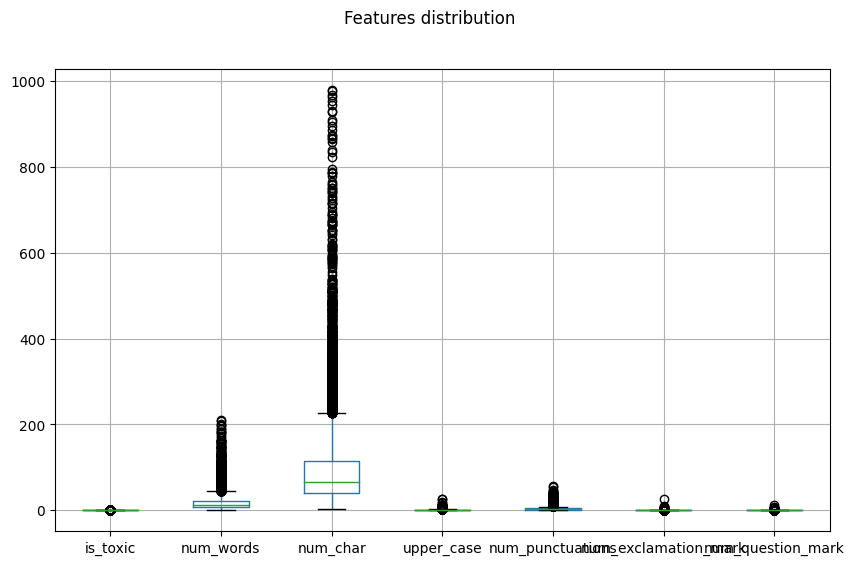

In [ ]:
# Remove outliers
df1 = df1[(df1['num_char']<1000)]
df1_boxplot = df1.boxplot(figsize= (10, 6))
plt.suptitle('Features distribution')

##**Visualization**

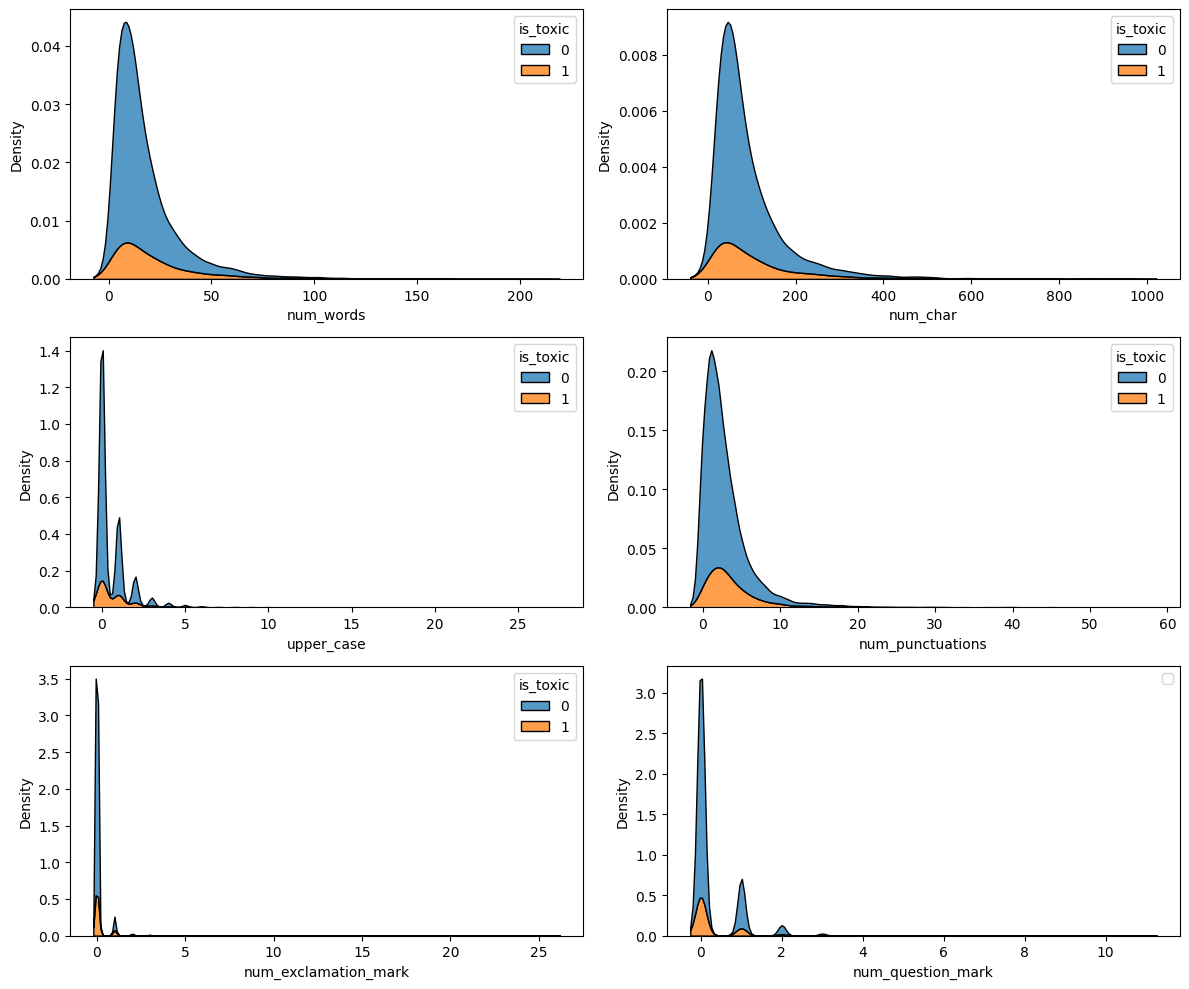

In [ ]:
# Plots
cols = ['num_words', 'num_char', 'upper_case', 'num_punctuations', 'num_exclamation_mark', 'num_question_mark']
fig, ax = plt.subplots(3, 2, figsize= (12, 10))
plt.subplots_adjust(hspace= 1.)
for i, num_col in enumerate(cols):
    row = i//2
    col = i%2
    sns.kdeplot(x = num_col, hue = 'is_toxic', data = df1, multiple= 'stack', ax = ax[row, col])
    plt.legend()
plt.tight_layout()
plt.show()

##**Text preprocessing**

In [ ]:
X = df1.drop(columns='is_toxic')
y = df1['is_toxic']
print(X.shape, y.shape)

(12880, 7) (12880,)


In [ ]:
# Vectorization
from collections import Counter
def tokenize_and_clean(text):
    # Changing case of the text to lower case
    lowered = text.lower()

    # Remove markups, hyperlinks, punctuations and symbols
    txt = re.sub('[0-9]+', '', lowered)
    txt = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', txt)
    txt = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', txt)
    txt = re.sub('&gt;', "", txt) # greater than sign
    txt = re.sub('&#x27;', "'", txt) # apostrophe
    txt = re.sub('&#x2F;', ' ', txt)
    txt = re.sub('<p>', ' ', txt) # paragraph tag
    txt = re.sub('<i>', ' ', txt) #italics tag
    txt = re.sub('</i>', '', txt)
    txt = re.sub('&#62;', '', txt)
    txt = re.sub("\n", '', txt) # newline

    # Tokenization
    tokens = word_tokenize(txt)
    filtered_tokens = [token for token in tokens if re.match(r'\w{1,}', token)]

    # Remove stop words
    filtered_tokens = [token for token in filtered_tokens if token not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    stems = [stemmer.stem(token) for token in filtered_tokens]

    return stems


In [ ]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize_and_clean, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(X['message'])
print(X_tfidf.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'thu', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'where

(12880, 12778)


In [ ]:
# Data partition
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size= 0.3, random_state= 42, stratify= y)
print('Training set shape:', X_train.shape, y_train.shape)
print(f'train y= 0: {len(y_train[y_train==0])}, y= 1: {len(y_train[y_train==1])}')
print('Test set shape:', X_test.shape, y_test.shape)
print(f'test y= 0: {len(y_test[y_test==0])}, y= 1: {len(y_test[y_test==1])}')

Training set shape: (9016, 12778) (9016,)
train y= 0: 7253, y= 1: 1763
Test set shape: (3864, 12778) (3864,)
test y= 0: 3109, y= 1: 755


##**Modeling and evaluation**

In [ ]:
def evaluate_model(X_train, y_train, X_test, y_test, pipe):
    model = pipe.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Balanced accuracy and F1-score
    balance_accuracy_test = balanced_accuracy_score(y_test, y_pred_test)
    f1_test = round(f1_score(y_test, y_pred_test), 5)
    print(f'Validation Scores: Balanced Accuracy={balance_accuracy_test}, F1-Score={f1_test}')
    print('Classification Report: \n', classification_report(y_test, y_pred_test))

    # Confusion matrix
    confusion_matrix_lr = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize= (10, 6))
    sns.heatmap(confusion_matrix_lr, annot = True, fmt= 'd', cmap= 'Blues', linewidths= 3, cbar= False)
    plt.xlabel('Predicted labels')
    plt.ylabel('Actual labels')
    plt.title('Confusion matrix')
    plt.xticks([0.5, 1.5], ['Predicted non-toxic', 'Predicted toxic'])
    plt.yticks([0.5, 1.5], ['Actual non-toxic', 'Actual toxic'])
    plt.show()

evaluate_pipeline = partial(evaluate_model, X_train, y_train, X_test, y_test)

Validation Scores: Balanced Accuracy=0.8439563412353368, F1-Score=0.74818
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      3109
           1       0.75      0.75      0.75       755

    accuracy                           0.90      3864
   macro avg       0.84      0.84      0.84      3864
weighted avg       0.90      0.90      0.90      3864



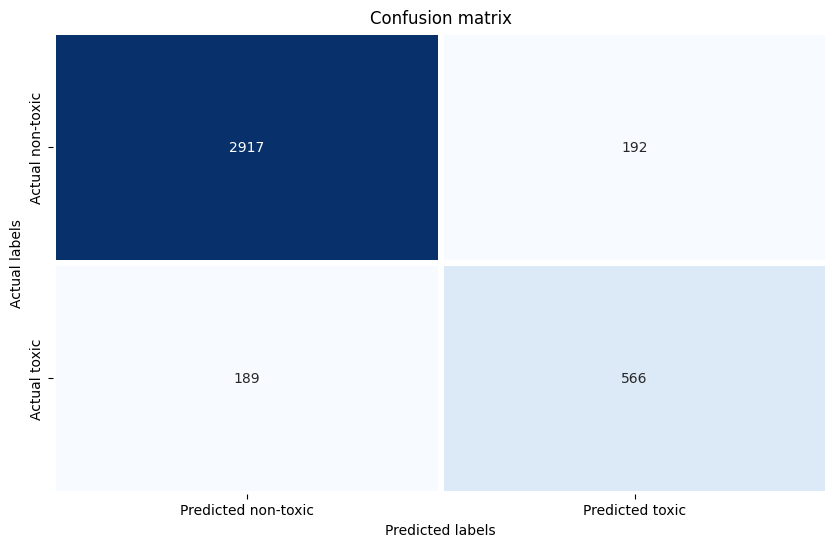

In [ ]:
# Logistic model vs oversampling
lr_pipe1 = Pipeline([
    ('sampler', RandomOverSampler(sampling_strategy= 'minority',random_state=42)),
    ('model', LogisticRegression())
])

evaluate_pipeline(lr_pipe1)

Validation Scores: Balanced Accuracy=0.8408163439192773, F1-Score=0.71585
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.90      0.92      3109
           1       0.66      0.78      0.72       755

    accuracy                           0.88      3864
   macro avg       0.80      0.84      0.82      3864
weighted avg       0.89      0.88      0.88      3864



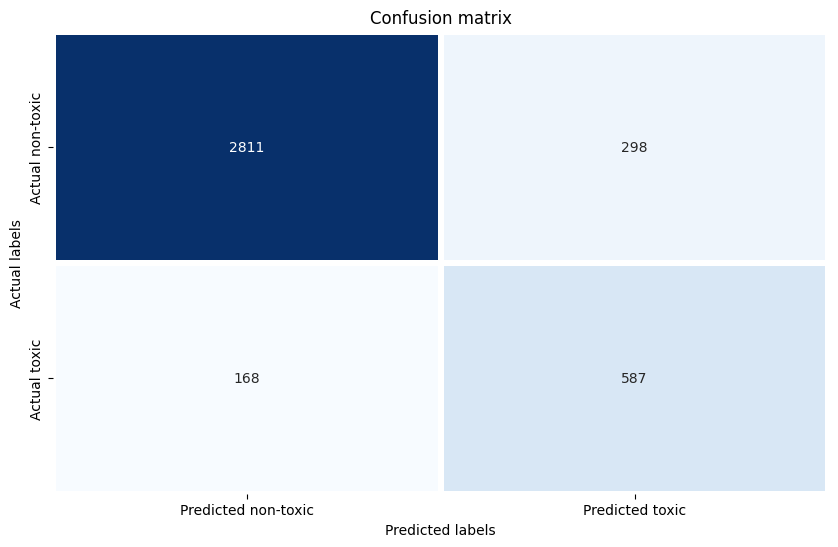

In [ ]:
# Logistic model vs undersampling
lr_pipe2 = Pipeline([
    ('sampler', RandomUnderSampler(sampling_strategy='majority',random_state=42)),
    ('model', LogisticRegression())
])

evaluate_pipeline(lr_pipe2)

Validation Scores: Balanced Accuracy=0.8510992440234397, F1-Score=0.75556
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      3109
           1       0.75      0.77      0.76       755

    accuracy                           0.90      3864
   macro avg       0.84      0.85      0.85      3864
weighted avg       0.90      0.90      0.90      3864



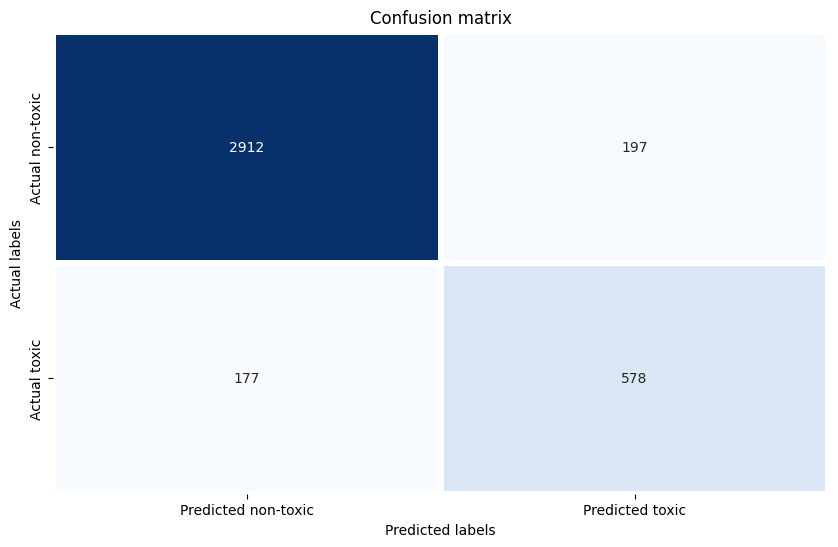

In [ ]:
# Weighted logistic regression
lr_pipe3 = Pipeline([
    ('model', LogisticRegression(class_weight='balanced'))
])

evaluate_pipeline(lr_pipe3)


Validation Scores: Balanced Accuracy=0.8303040308099323, F1-Score=0.74598
Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      3109
           1       0.79      0.71      0.75       755

    accuracy                           0.91      3864
   macro avg       0.86      0.83      0.84      3864
weighted avg       0.90      0.91      0.90      3864



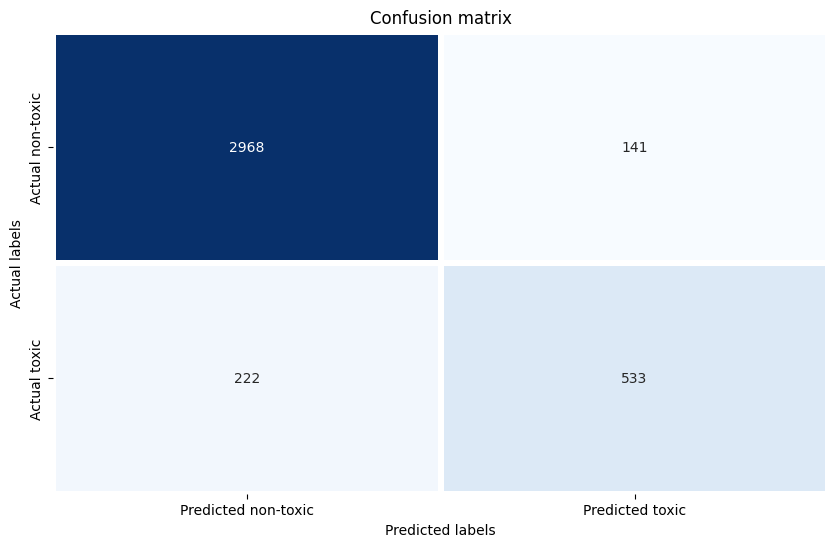

In [ ]:
# Random Forrest and oversampling
rf_pipe1 = Pipeline([
    ('sampler', RandomOverSampler(sampling_strategy= 'minority',random_state=42)),
    ('model', RandomForestClassifier(min_samples_split=5))
])

evaluate_pipeline(rf_pipe1)

Validation Scores: Balanced Accuracy=0.8494354139552123, F1-Score=0.71689
Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.89      0.92      3109
           1       0.65      0.81      0.72       755

    accuracy                           0.88      3864
   macro avg       0.80      0.85      0.82      3864
weighted avg       0.89      0.88      0.88      3864



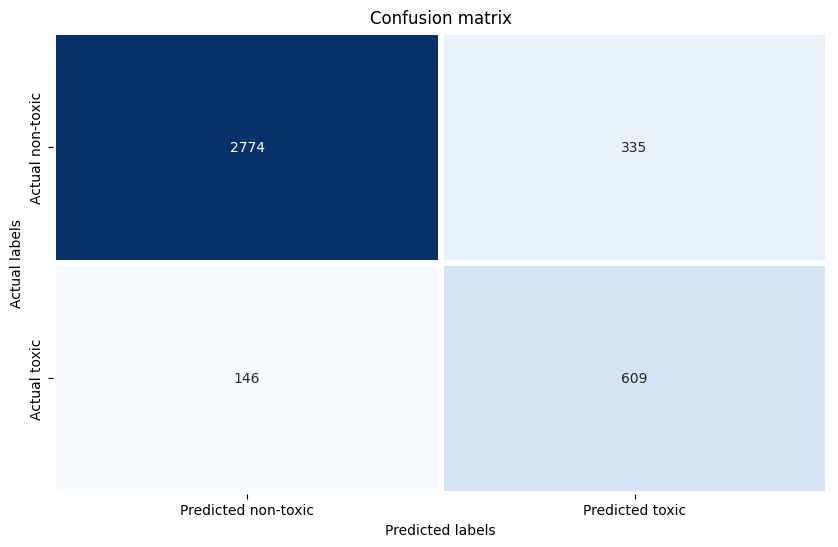

In [ ]:
#  Random Forrest and undersampling
rf_pipe2 = Pipeline([
    ('sampler', RandomUnderSampler(sampling_strategy='majority',random_state=42)),
    ('model', RandomForestClassifier(min_samples_split=5))
])

evaluate_pipeline(rf_pipe2)

Validation Scores: Balanced Accuracy=0.819016996159409, F1-Score=0.74357
Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.97      0.95      3109
           1       0.83      0.67      0.74       755

    accuracy                           0.91      3864
   macro avg       0.88      0.82      0.84      3864
weighted avg       0.91      0.91      0.91      3864



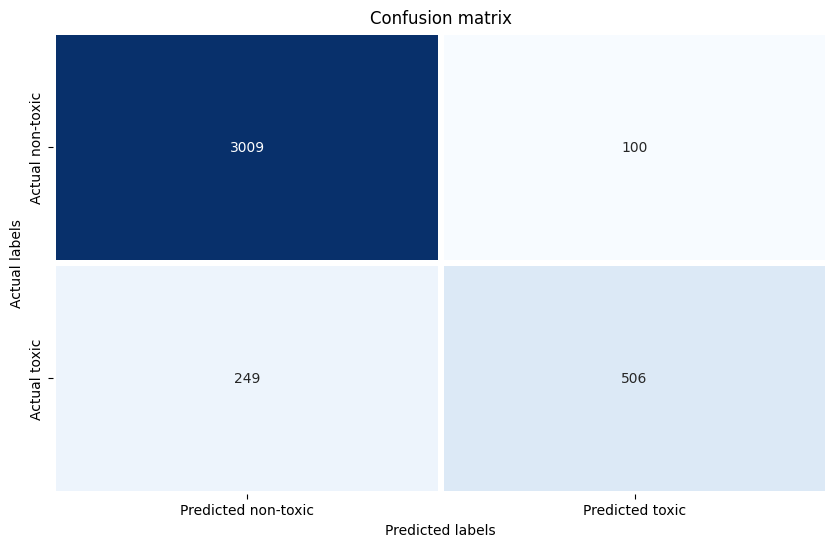

In [ ]:
#  Random Forrest with class weighting
rf_pipe3 = Pipeline([
    ('model', RandomForestClassifier(min_samples_split=5, class_weight = 'balanced'))
])

evaluate_pipeline(rf_pipe3)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:24:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_iter_no_change" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Scores: Balanced Accuracy=0.8723952464432463, F1-Score=0.78525
Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.94      0.95      3109
           1       0.77      0.80      0.79       755

    accuracy                           0.91      3864
   macro avg       0.86      0.87      0.87      3864
weighted avg       0.92      0.91      0.91      3864



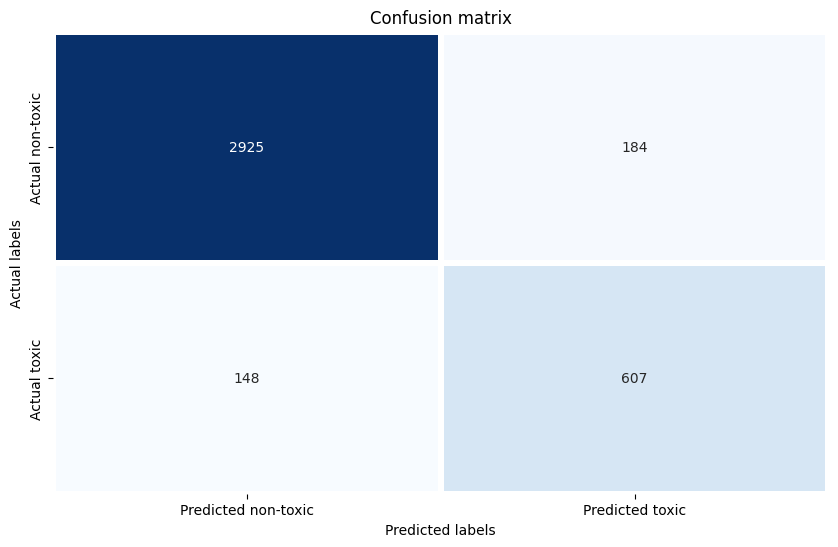

In [ ]:
# XGBoost and oversampling
xgb_pipe1 = Pipeline([
    ('sampler', RandomOverSampler(sampling_strategy= 'minority',random_state=42)),
    ('model', XGBClassifier(objective='binary:logistic', n_iter_no_change =5, eval_metric='logloss'))
])

evaluate_pipeline(xgb_pipe1)

Validation Scores: Balanced Accuracy=0.8668422588554059, F1-Score=0.76327
Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.92      0.94      3109
           1       0.72      0.81      0.76       755

    accuracy                           0.90      3864
   macro avg       0.84      0.87      0.85      3864
weighted avg       0.91      0.90      0.90      3864



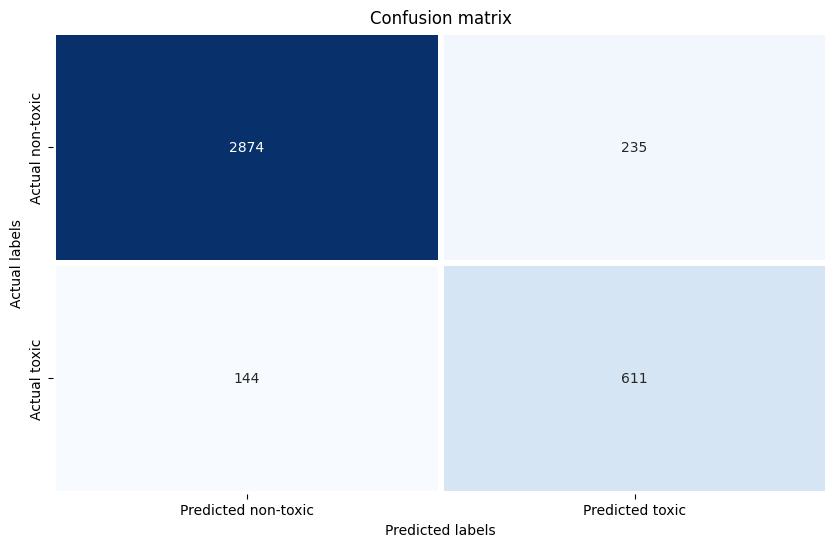

In [ ]:
#  XGBoost and undersampling
xgb_pipe2 = Pipeline([
    ('sampler', RandomUnderSampler(sampling_strategy='majority',random_state=42)),
    ('model', XGBClassifier(objective='binary:logistic', n_iter_no_change =5, eval_metric='logloss'))
])

evaluate_pipeline(xgb_pipe2)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [02:28:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Scores: Balanced Accuracy=0.814730998873171, F1-Score=0.74772
Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      3109
           1       0.88      0.65      0.75       755

    accuracy                           0.91      3864
   macro avg       0.90      0.81      0.85      3864
weighted avg       0.91      0.91      0.91      3864



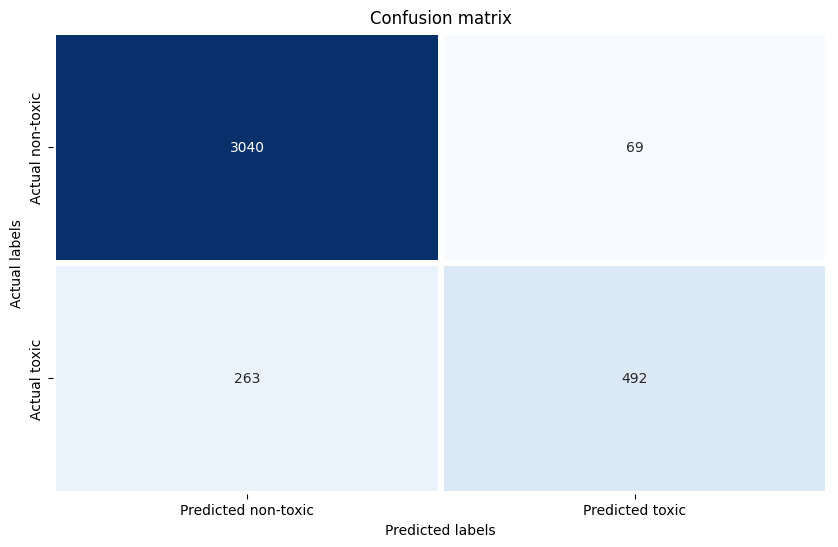

In [ ]:
#  XGBoost with class weighting
xgb_pipe3 = Pipeline([
    ('model', XGBClassifier(objective='binary:logistic', n_iter_no_change =5, eval_metric='logloss', class_weight = 'balanced'))
])

evaluate_pipeline(xgb_pipe3)

Validation Scores: Balanced Accuracy=0.8293299308352806, F1-Score=0.73306
Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.94      0.94      3109
           1       0.75      0.72      0.73       755

    accuracy                           0.90      3864
   macro avg       0.84      0.83      0.84      3864
weighted avg       0.90      0.90      0.90      3864



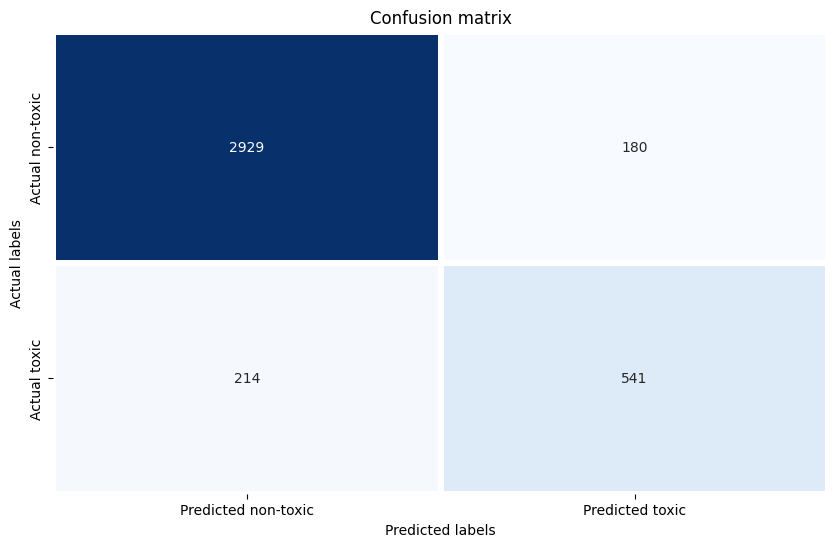

In [ ]:
#  SVM and oversampling
svm_pipe1 = Pipeline([
    ('sampler', RandomOverSampler(sampling_strategy='minority',random_state=42)),
    ('model', LinearSVC(class_weight='balanced', random_state= 42))
])

evaluate_pipeline(svm_pipe1)

Validation Scores: Balanced Accuracy=0.8465687099405912, F1-Score=0.71624
Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.90      0.92      3109
           1       0.65      0.80      0.72       755

    accuracy                           0.88      3864
   macro avg       0.80      0.85      0.82      3864
weighted avg       0.89      0.88      0.88      3864



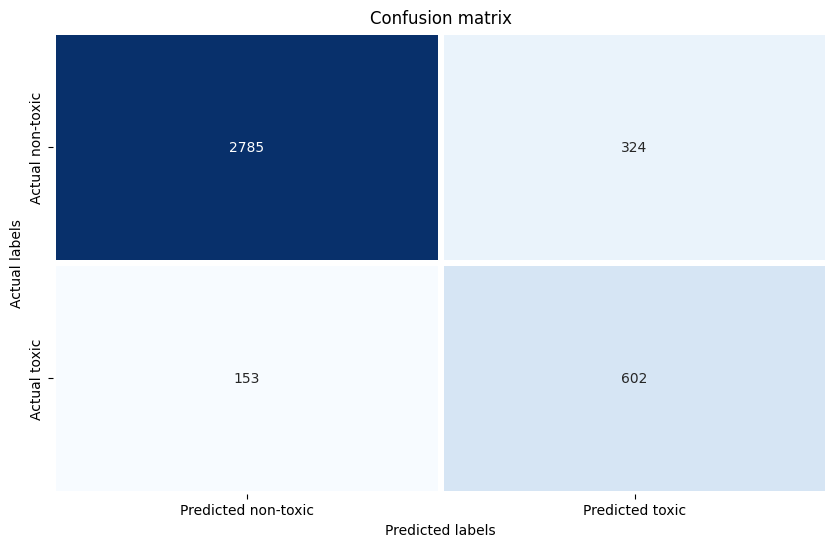

In [ ]:
#  SVM and undersampling
svm_pipe2 = Pipeline([
    ('sampler', RandomUnderSampler(sampling_strategy='majority',random_state=42)),
    ('model', LinearSVC(class_weight='balanced', random_state= 42))
])

evaluate_pipeline(svm_pipe2)

Validation Scores: Balanced Accuracy=0.837475690102863, F1-Score=0.74148
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      3109
           1       0.75      0.74      0.74       755

    accuracy                           0.90      3864
   macro avg       0.84      0.84      0.84      3864
weighted avg       0.90      0.90      0.90      3864



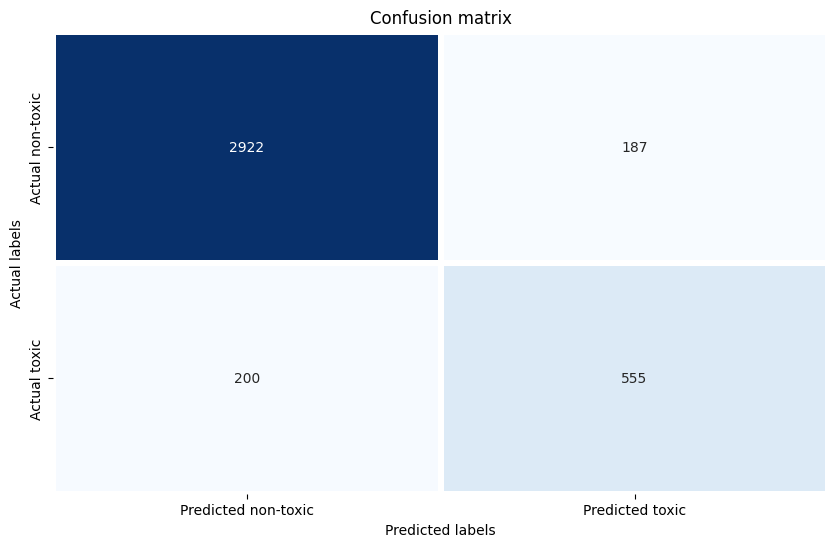

In [ ]:
# SVM with class weighting
svm_pipe3 = Pipeline([
    ('model', LinearSVC(class_weight='balanced', random_state= 42))
])

evaluate_pipeline(svm_pipe3)